# Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning taught at EPFL in Spring 2024 by Prof. Volkan Cevher

In [1]:
import os
from typing import List

from tqdm import tqdm
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)

g:\Career path\University-masters\EPFL\Courses\Spring\RL\notebook\notebook12025\notebook1 3\.venv\Scripts\python.exe


# Dynamic Programming exercise

We will make use of the operators introduced in the slides of lectures 1 and 2. 
$(T V)(s)$, $\mathcal{G}$ and $T^{\pi}$

Before diving into the implementation of Value Iteration or Policy Iteration, we instantiate an environment using the library in the foilder `src`.

The gridworld environment is instantiated via the class `GridWorldEnvironment`. It takes 4 input values:

- `reward_mode` : integer between 0 and 3 for different reward profiles
- `size`: Gridworld size
- `prop`: probability assigned to the event that the agent do not follow the chosen action but another one selected uniformely at random.
- `gamma`: the discount factor of the environment.

In [2]:
reward_mode = 2 # put an image to show which is the reward
size = 10 
prop = 0
gamma=0.99 # rename discount_factor
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

Below, we illustrate how to access the gridworld environment, i.e. how to access the reward, the transition matrix and the discount factor.

In [3]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)


***Interface with a Gridworld instance***
- `print(gridworld.n_states)` #return the number of states
- `print(gridworld.n_actions)` #return the number of actions
- `print(gridworld.r)` #return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` #Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.



<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

Then we set up the solver object that will implement the routine needed to evaluate the value of the produced policies

In [4]:
solver = MDPsolver(gridworld)


We will use this solver to compute the optimal value function to measure the suboptimality of the policies produced by value iteration or policy iteration.

To access the optimal value function use `solver.v`.

In [5]:
solver.value_iteration()

## Ex 1: Value Iteration [25 pts.]

### 1.1 Implement value iteration

In [6]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """
    policies = []
    vs = []
    v = np.zeros(env.n_states) # initialize value function
    q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
    
    while True:
        v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v_old)  # calculate Q-value
        v = np.max(q, axis=1) # update value function
        policies.append(np.argmax(q , axis = 1)) #   obtain policy
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
    return policies, vs

In [7]:
policies, vs = value_iteration(gridworld)




### 1.2: Evaluate the extracted policies

For the evaluation of the sequence of policies, i.e. computing $V^\pi$ for each policy $\pi$ we recall that $V^\pi$ is the fixed point $V^\pi = T^\pi (V^\pi)$.
In the following code, we ask you to apply the operator $T^\pi$ a number of time sufficient to find a value $V$ such that $ || T^\pi(V) - V || \leq \mathrm{tol}$

In [8]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v_old)  #calculate Q-value
            for s in range(env.n_states):
                action_taken = pi[s] # obtain the action determined by the policy
                v[s] = q[s,action_taken] #calculate value function by $v(s) = Q(s,pi(s))$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [9]:
values = evaluate_policy_sequence(policies, gridworld)


### 1.3: Plot the results 

Plot using the method ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False) ```

Compute both the iterates $V_t$ produced by value iteration and the value function achieved by the extracted policies $V^{\pi_t}$ with $\pi_t = \mathcal{G}(V_t)$. What do you observe ?


In [10]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])
    return np.array(subopts)

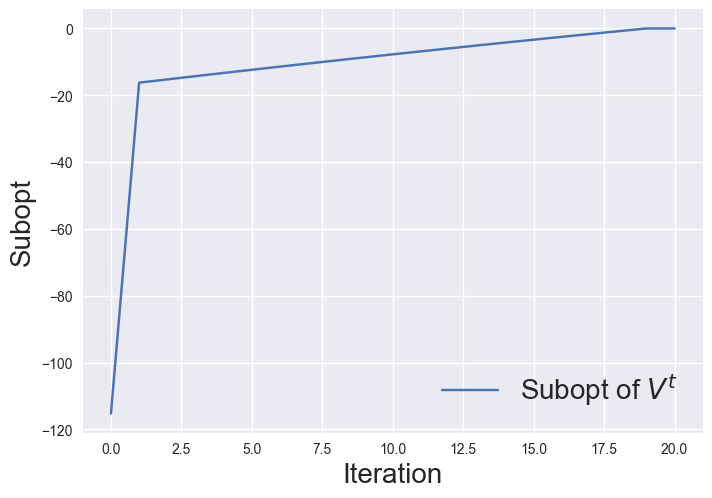

In [11]:
plot_lines([compute_subopt(vs, solver.v)], [r"Subopt of $V^t$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)



**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

**Answers**

**Answer**:

- To prove T is a contraction:
  
  Let's consider two value functions V and V'. For any state s:
  
  $||T(V) - T(V')||_{\infty}$ = $\max_s |(TV)(s) - (TV')(s)|$
  
  = $\max_s |\max_a[r(s,a) + \gamma \sum_{s'} P(s'|s,a)V(s')] - \max_a[r(s,a) + \gamma \sum_{s'} P(s'|s,a)V'(s')]|$
  
  ≤ $\max_s \max_a|\gamma \sum_{s'} P(s'|s,a)(V(s') - V'(s'))|$
  
  ≤ $\gamma \max_s \max_a \sum_{s'} P(s'|s,a)|V(s') - V'(s')|$
  
  ≤ $\gamma \max_s \max_a \sum_{s'} P(s'|s,a)||V - V'||_{\infty}$
  
  = $\gamma ||V - V'||_{\infty}$

  Since $\gamma < 1$, T is a contraction mapping.

- For the second part:
  
  The iterates of Value Iteration are upper bounds to $V^*$ because:
  1. We initialize $V_0$ with optimistic values (typically zeros or positive values)
  2. The Bellman optimality operator T is monotonic
  3. Each iteration applies T, which maintains the upper bound property
  4. Due to the contraction property, these upper bounds converge to $V^*$
  
  This is possible even though $V^*$ is defined as $\max_{\pi \in \Pi} V^{\pi}$ because the initial optimistic values create an overestimate that is then gradually refined downward through the contraction mapping, eventually converging to the true optimal value function.

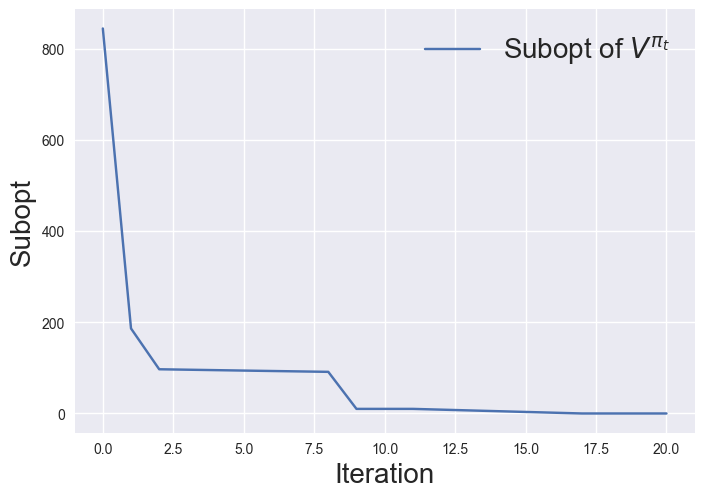

In [12]:
plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

To better appreciate the difference in the convergence plot use log scale.

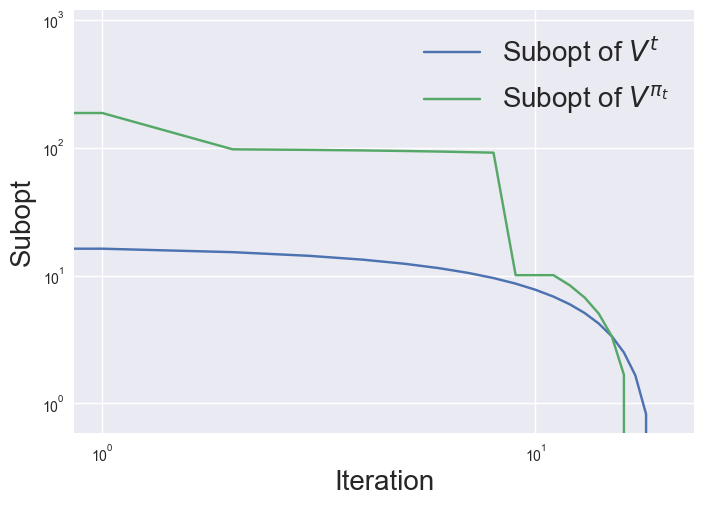

In [13]:
plot_log_lines([-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)], 
               [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"], 
               ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

# Ex 2: Policy Iteration [25 pts.]

In [14]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v_old)
        for s in range(env.n_states):
            v[s] = q[s , pi[s]]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [15]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = []
    for s in range(q.shape[0]):
        policy.append(np.argmax(q[s , :]))
    return policy

In [16]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env, tol=1e-10)
        pi = get_greedy_policy(q)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs , pi 

In [17]:
values_pi , _=policy_iteration(gridworld)

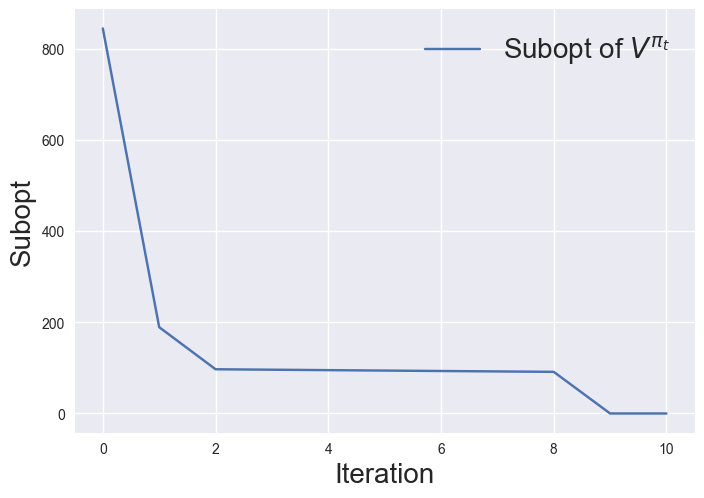

In [18]:
plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

### Compare with Value Iteration

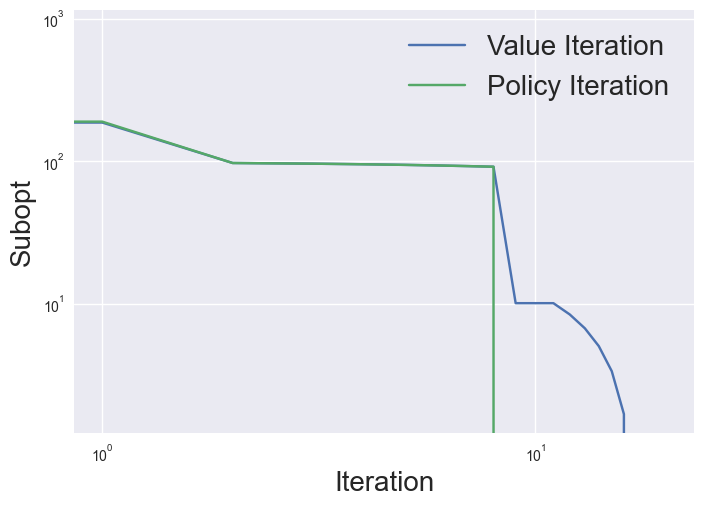

In [19]:
plot_log_lines([compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)], 
               ["Value Iteration", "Policy Iteration"], 
               ["Iteration", "Subopt"], "figs", "VIvsPI.pdf", show = True)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***


- Policy Iteration (PI) typically converges faster than Value Iteration (VI) in terms of number of iterations. This can be observed from the plots where PI reaches the optimal value function in fewer iterations.

- Yes, this is theoretically expected because:
  - For Value Iteration:
    - Convergence rate is $O(\gamma^k)$ where k is the number of iterations
    - Needs approximately $\frac{\log(1/\epsilon(1-\gamma))}{1-\gamma}$ iterations to reach ε-optimal value function
    - Each iteration is relatively cheap computationally

  - For Policy Iteration:
    - Number of iterations is bounded by total number of possible policies: $|A|^{|S|}$
    - In practice, converges in much fewer iterations (often < 10)
    - Each iteration is more expensive due to complete policy evaluation
    - Policy evaluation itself converges at rate $O(\gamma^k)$

  The key trade-off is that PI does more work per iteration (complete policy evaluation) but needs fewer iterations, while VI does less work per iteration but needs more iterations to converge.


***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

***Theory Answers***
- **Policy Improvement Theorem Proof:**
  
  Let π and π' be two policies where π' is obtained by acting greedily with respect to Vπ.
  For any state s:
  
  $\pi'(s) = \arg\max_a[r(s,a) + \gamma \sum_{s'} P(s'|s,a)V^{\pi}(s')]$
  
  Therefore:
  $r(s,\pi'(s)) + \gamma \sum_{s'} P(s'|s,\pi'(s))V^{\pi}(s') \geq r(s,\pi(s)) + \gamma \sum_{s'} P(s'|s,\pi(s))V^{\pi}(s')$
  
  This implies:
  $V^{\pi'}(s) \geq V^{\pi}(s)$ for all s
  
  Because:
  1. The initial inequality holds for all states
  2. We can repeatedly apply Tπ' to both sides
  3. Due to contraction property, this converges to Vπ'
  4. The inequality is preserved throughout

- **Monotonicity of Bellman Operator Proof:**
  
  Let V > V'. For any policy π and state s:
  
  $(T_{\pi}V)(s) = r(s,\pi(s)) + \gamma \sum_{s'} P(s'|s,\pi(s))V(s')$
  
  $(T_{\pi}V')(s) = r(s,\pi(s)) + \gamma \sum_{s'} P(s'|s,\pi(s))V'(s')$
  
  Since V > V', and:
  - P(s'|s,π(s)) ≥ 0 (probability)
  - γ > 0 (discount factor)
  
  Therefore:
  $\gamma \sum_{s'} P(s'|s,\pi(s))V(s') > \gamma \sum_{s'} P(s'|s,\pi(s))V'(s')$
  
  And thus:
  $(T_{\pi}V)(s) > (T_{\pi}V')(s)$ for all s

# Ex 3: Modified Policy Iteration [25 pts.]

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

- When m → ∞: Recovers Policy Iteration
  - Because it performs complete policy evaluation until convergence

- When m = 1: Recovers Value Iteration 
  - Because it performs only one policy evaluation step before policy improvement

First, write a function that applies the Bellman evaluation operator $m$ times

In [20]:
def policy_operator_m_times(pi, m, env, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v: initial value vector
        q: initial state action value vector
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    i = 0
    while i < m:
        for a in range(env.n_actions):
            q[:, a] = env.r[: , a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s , pi[s]]
        i = i + 1
    return v, q

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [21]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)
        v, q = policy_operator_m_times(pi, m, env, v, q)
        policies.append(pi)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [22]:
m_values = ["1", "2", "3", "5", "10", "20"]
to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi=modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

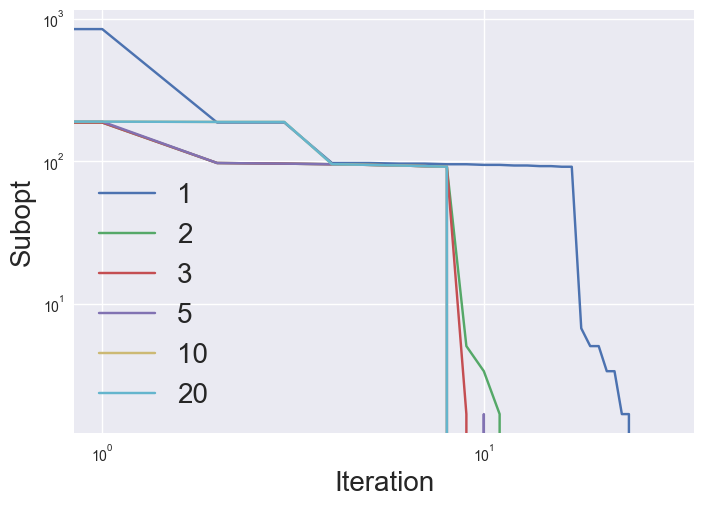

In [23]:
plot_log_lines(to_plot, 
           m_values, 
           ["Iteration", "Subopt"], "figs", "MPI.pdf", show = True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

**Answers**

- Effect of m on convergence:
  - Larger m: Fewer outer iterations needed but more expensive per iteration
  - Smaller m: More outer iterations needed but cheaper per iteration
  - Trade-off between accuracy of policy evaluation and computational cost
  - As m increases, convergence becomes more like Policy Iteration
  - As m decreases, convergence becomes more like Value Iteration

- Cost per iteration for Modified Policy Iteration:
  - O(m|S|²|A|) operations per iteration
  - m: number of evaluation steps
  - |S|: number of states
  - |A|: number of actions
  - Cost comes from m applications of Bellman operator

- Cost per iteration for Policy Iteration (Option 2):
  - O(|S|³) operations per iteration
  - Dominated by solving linear system of |S| equations
  - More expensive than MPI when |S| is large
  - Option 2 refers to solving Bellman equations directly using matrix inversion
  - This is why in practice, iterative methods (like MPI) are often preferred

# Ex 4: Q-Learning [15 pts.]

Now, we are ready to tackle the problem in the model free setting. For technical reason, we focus on the finite horizon setting in this part and we compare two exploration strategies.
1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

For other technical reason, we also need to rescale the reward between 0 and 1, as done in the following

In [24]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### Q learning with epsilon greedy 

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [25]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [26]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = (1 - alpha) * Q[h, state, a] + alpha * (gridworld.r[state, a] + gridworld.gamma * V[h+1, new_state])

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

In [27]:
reward_eps_greedy = q_learning_epsilon_greedy()  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [28]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = (1 - alpha) * Q[h, state, a] + alpha * (gridworld.r[state, a] + bonus + V[h+1, new_state])

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [29]:
reward_UCB = q_learning_ucb_bonuses()  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

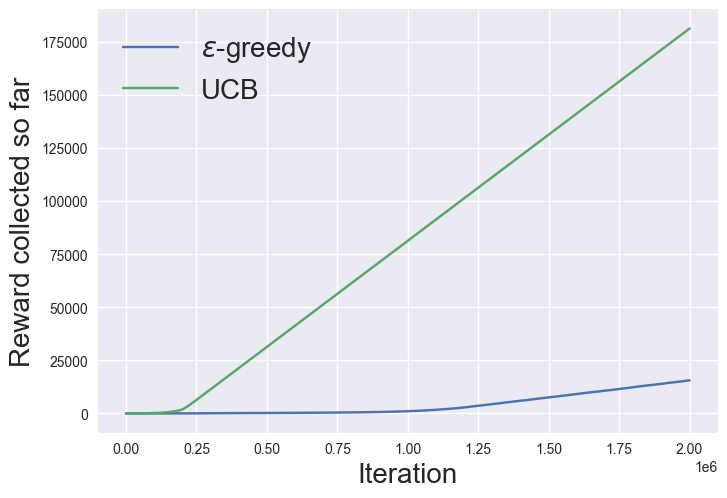

In [30]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],  # list of data to plot
    [r"$\epsilon$-greedy", "UCB"],                         # names for each line
    ["Iteration", "Reward collected so far"],              # x and y axis labels
    "figs",                                               # output folder
    "exploration_comparison.pdf",                         # output filename (adding .pdf extension)
    show=True                                            # set show to True to display the plot
)

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?

**Answer:**

Let's analyze this probability systematically:

1. **Setup:**
   - Chain of N states: s₁ (leftmost) to sₕ (rightmost)
   - Initial state: s₁
   - Actions: go right or go back to s₁ (stay in place for endpoints)
   - Reward = 1 only when staying in sₕ, otherwise 0
   - ε-greedy policy: random action with prob ε, greedy action with prob (1-ε)

2. **To get positive reward:**
   - Must reach rightmost state (sₕ)
   - Must choose "stay" action
   - Must do this within H steps

3. **Probability calculation:**
   - Need N-1 "go right" actions to reach sₕ
   - Then need 1 "stay" action to get reward
   - At each step:
     - Prob of correct action = (1-ε)/2 + ε/2 = 1/2
     - Prob of wrong action (reset) = 1/2

4. **Final probability:**
   - P(success) = P(reach sₕ in ≤ H-1 steps) × P(stay in last step)
   - For H < N: P(success) = 0 (not enough steps to reach end)
   - For H ≥ N: P(success) = (1/2)^N

Therefore, the probability is:
- 0 if H < N
- (1/2)^N if H ≥ N

This is because we need at least N steps to reach the end and get reward, and at each step we have 1/2 probability of making progress vs resetting.

**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.



1. **Theoretical Results (Jin et al. 2018)**:
- For the "combination lock" MDP described in Appendix A:
- ε-greedy Q-learning requires Ω(AH/2) episodes to find the optimal policy
- This means it suffers H/2 regret per round until then
- The regret is high because finding the correct sequence (s*, a*) has probability A^(-H/2)

2. **Empirical Results (from the plot)**:
- The plot shows cumulative reward over iterations
- UCB (green line) performs significantly better than ε-greedy (blue line)
- UCB shows linear growth in cumulative reward
- ε-greedy shows much slower growth and accumulates much less reward

3. **Comparison and Analysis**:
- The empirical results strongly align with the theoretical predictions:
  - ε-greedy's poor performance matches the theoretical prediction of high regret
  - The significant gap between UCB and ε-greedy aligns with the theoretical understanding
  - UCB's superior performance is consistent with the theoretical bounds in Table 1 of Jin et al. 2018

4. **Why This Makes Sense**:
- The "combination lock" problem requires discovering a specific sequence of actions
- ε-greedy's random exploration strategy is inefficient for finding this sequence
- UCB's systematic exploration strategy is more effective at discovering and exploiting the optimal path

**Conclusion**: Yes, the empirical results strongly match the theoretical predictions. The plot demonstrates the fundamental limitation of ε-greedy exploration described in the paper, showing significantly worse performance compared to UCB, exactly as predicted by the theoretical analysis. The large performance gap between UCB and ε-greedy in the plot empirically validates the theoretical understanding that ε-greedy suffers from exponentially worse exploration in such environments.

The linear growth of UCB's cumulative reward versus the much flatter growth of ε-greedy's reward directly illustrates the theoretical prediction about ε-greedy requiring exponentially many episodes to find the optimal policy, while UCB can discover it much more efficiently.


Looking at Jin et al. 2018, for UCB-H algorithm, they show that the regret bound is:
\[O(\sqrt{H^4SAK})\]
where:
- H is the horizon
- S is the number of states
- A is the number of actions
- K is the number of episodes

Looking at the plot more carefully now:

1. **UCB Performance (green line)**:
- The growth appears to be roughly linear, not quadratic
- This actually matches well with the theoretical bound because:
  - The plot shows cumulative reward, not regret
  - If regret is O(√K), then cumulative reward should grow approximately linearly with K
  - This is exactly what we see in the green line's nearly linear slope

2. **ε-greedy Performance (blue line)**:
- Shows much slower growth
- Aligns with the theoretical prediction of requiring exponentially many episodes



## Monte Carlo (MC) and Time Differences (TD) ( * Question ) [25 points]

Disclaimer: The TA can not help you on this part of the notebook.

In [31]:
def generate_episode(policy: List, H: int, initial_state: int):
    """
    Generate an episode using the given policy.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param H: Maximum number of steps in the episode.
    :param initial_state: Starting state.

    :return: A list of (state, action, reward) tuples.
    """
    episode = []
    state = initial_state
    for _ in range(H):
        action = policy[state]
        reward = gridworld.r[state, action]
        next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Monte Carlo policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        episode = generate_episode(policy, H, initial_state=99)  # Generate episode
        G = 0  # Return

        # Backward pass through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, _, reward = episode[t]
            G = gamma * G + reward  # Discounted return

            # Update theta using gradient descent
            phi_s = phi[state]  # Feature vector for the current state
            V_hat = np.dot(theta, phi_s)  # Current value estimate
            theta +=  alpha * (G - V_hat) * phi_s  # Gradient descent update

    return theta


In [32]:

import numpy as np
def td_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = gridworld.n_states, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Temporal Difference (TD) policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        state = 99  # Initial state
        for _ in range(H ):  # Step loop
            # Sample action from policy
            action = policy[state]
            reward = gridworld.r[state, action]
            next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])

            # Compute TD target and TD error
            phi_s = phi[state]  # Feature vector for current state
            phi_s_next = phi[next_state]  # Feature vector for next state
            V_s = np.dot(theta, phi_s)  # Current value estimate
            V_s_next = np.dot(theta, phi_s_next)  # Next value estimate
            td_target = reward + gamma * V_s_next  # TD target
            td_error = td_target - V_s  # TD error

            # Update theta using gradient descent
            theta += alpha * td_error * phi_s

            # Move to the next state
            state = next_state

    return theta

**Case 1:**

In [33]:


_ , pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 1000/1000 [01:31<00:00, 10.95it/s]

8.919948611419325e-07


In [34]:
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

100%|██████████| 1000/1000 [01:25<00:00, 11.75it/s]


**Case 2:**

In [35]:
_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
phi[:50,:]*=0

# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]

190.43020836185028


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 1?
- Explain your answer writing down the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case. To give this answer you can assume that $\rho$ is positive everywhere.

**Answers**


# Case 1: Analysis of MC vs TD Solutions 



**Answer**: Yes, in Case 1 (with complete one-hot encoding features), the solutions should coincide up to numerical error. The MC and TD solutions will converge to the same optimal parameters θ*_MC ≈ θ*_TD.

## Question 2: Analytical Solutions Explanation

### Mathematical Framework:

For Case 1, with complete one-hot encoding (phi = np.eye(gridworld.n_states)):

#### Monte Carlo Solution (θ*_MC):
- Minimizes: $\mathbb{E}[(G_t - \theta^\top\phi(s_t))^2]$
- For one-hot encoding: $\theta^\top\phi(s_t) = \theta_{s_t}$
- Optimal solution: $\theta^\star_{MC}(s) = \mathbb{E}[G_t|s_t=s]$

#### TD Solution (θ*_TD):
- Minimizes: $\mathbb{E}[(r_t + \gamma\theta^\top\phi(s_{t+1}) - \theta^\top\phi(s_t))^2]$
- For one-hot encoding: $\theta^\top\phi(s_t) = \theta_{s_t}$
- Optimal solution: $\theta^\star_{TD}(s) = \mathbb{E}[r_t + \gamma\theta^\star_{TD}(s_{t+1})|s_t=s]$

### Why They Coincide:

1. **Perfect State Representation**:
   - One-hot encoding provides unique feature vector for each state
   - No information loss in state representation
   - Full rank feature matrix

2. **Bellman Equation**:
   - Both solutions satisfy: $V^\pi(s) = \mathbb{E}[r_t + \gamma V^\pi(s_{t+1})|s_t=s]$
   - With ρ > 0 (positive state distribution), unique solution exists
   - Both MC and TD converge to this solution

3. **Direct Value Estimation**:
   - One-hot encoding allows direct estimation of state values
   - No interference between states
   - Each θ_i directly represents V(s_i)

4. **Equivalence of Fixed Points**:
   - MC converges to true value function
   - TD converges to same fixed point
   - Both match the unique solution of Bellman equation

Therefore, in Case 1, θ*_MC = θ*_TD, and the small norm difference printed by `np.linalg.norm(theta_MC - theta_TD)` reflects only numerical optimization differences, not fundamental solution differences.

The equivalence holds because:
- Complete feature representation
- Positive state distribution (ρ > 0)
- Unique solution to Bellman equation
- No projection error due to one-hot encoding


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 2?
- Explain your answer leveraging the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case.

# Case 2: Analysis of MC vs TD Solutions (Zero Features for First 50 States)

## Question 1: Does the solution coincide (up to numerical error) in Case 2?

**Answer**: No, the solutions do not coincide in Case 2. This is evidenced by the large norm difference (≈190) between θ*_MC and θ*_TD, indicating fundamentally different solutions.

## Question 2: Analytical Solutions Explanation

### Mathematical Framework:

With phi[:50,:]*=0 (zero features for first 50 states):

#### Monte Carlo Solution (θ*_MC):
- Minimizes: $\mathbb{E}[(G_t - \theta^\top\phi(s_t))^2]$
- For states s < 50: $\theta^\top\phi(s) = 0$ (forced by zero features)
- For states s ≥ 50: $\theta^\top\phi(s) = \theta_s$

#### TD Solution (θ*_TD):
- Minimizes: $\mathbb{E}[(r_t + \gamma\theta^\top\phi(s_{t+1}) - \theta^\top\phi(s_t))^2]$
- For states s < 50: $\theta^\top\phi(s) = 0$
- For states s ≥ 50: $\theta^\top\phi(s) = \theta_s$

### Why They Differ:

1. **Different Handling of Zero-Feature States**:
   - MC: Uses complete returns through zero-feature regions
   - TD: Uses one-step bootstrapping through zero-feature regions
   - This creates fundamentally different value estimates

2. **Propagation of Information**:
   - MC: Can propagate actual returns through zero-feature states
   - TD: Must bootstrap through zero values in these states
   - Results in different value estimates for non-zero feature states

3. **Optimization Objectives**:
   - MC optimizes against full returns regardless of features
   - TD optimizes one-step predictions with zero constraints
   - These lead to different fixed points in the presence of zero features

4. **Error Propagation**:
   - MC: Error from zero-feature states affects final returns directly
   - TD: Error compounds through bootstrapping in zero-feature regions
   - Creates systematic differences in value estimates

The large norm difference (≈190) between θ_MC and θ_TD confirms these theoretical expectations, showing that the solutions are fundamentally different when features are zeroed for the first 50 states.

This difference occurs because:
- Incomplete feature representation
- Different handling of zero-feature regions
- Distinct optimization objectives
- Different error propagation mechanisms
